# General notebook for testing purpose

Dashboard: https://developer.riotgames.com/  
Region endpoints: https://developer.riotgames.com/regional-endpoints.html  
Full reference: https://developer.riotgames.com/api-methods/

In [130]:
import requests
import pandas as pd

%matplotlib inline
import matplotlib
matplotlib.style.use("ggplot")

In [131]:
def get_json(url):
    return requests.get(url).json()

def get_summoner_data(region, summoner_name, api_key):
    url = 'https://{}.api.riotgames.com/lol/summoner/v3/summoners/by-name/{}?api_key={}'.format(
        region,
        summoner_name,
        api_key
    )
    return get_json(url)

def get_summoner_league(summoner_id, region, api_key):
    url = 'https://{}.api.riotgames.com/lol/league/v3/positions/by-summoner/{}?api_key={}'.format(
        region,
        summoner_id,
        api_key
    )
    return get_json(url)

In [132]:
region = "euw1"
summoner_name = "Cyrlop"
api_key = "RGAPI-7b019907-bb60-4c90-9d36-c69f2d39ee7c"
summoner_names = ["Cyrlop", "Helluin", "leag"]

## Summoners

In [133]:
json_summ_list = [get_summoner_data(region, summoner_name, api_key) for summoner_name in summoner_names]

In [134]:
df_summoners = pd.DataFrame(json_summ_list).set_index("name")
df_summoners

,accountId,id,profileIconId,revisionDate,summonerLevel
name,,,,,
Cyrlop,29238184,24732627,3226,1519482189000,63
Helluin,21603599,376152,19,1519469507000,56
leaG,239556,233829,661,1495764755000,30


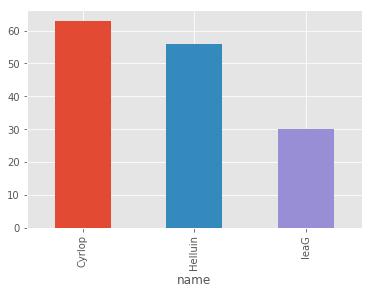

In [142]:
df_summoners["summonerLevel"].plot.bar()

## Leagues

In [143]:
json_league_list = [get_summoner_league(summoner_id, region, api_key) for summoner_id in df_summoners["id"]]

In [156]:
leagues = []
for l in json_league_list:
    for e in l:
        leagues.append(e)
df_leagues = pd.DataFrame(leagues)#.set_index("name")
df_leagues

,freshBlood,hotStreak,inactive,leagueId,leagueName,leaguePoints,losses,playerOrTeamId,playerOrTeamName,queueType,rank,tier,veteran,wins
0,False,False,False,98fcdbf0-fc9e-11e7-972b-c81f66dacb22,Zed's Spellswords,95,37,24732627,Cyrlop,RANKED_SOLO_5x5,IV,GOLD,False,40
1,False,False,False,adf0deb0-fa93-11e7-964f-c81f66dd0e0d,Trundle's Spellswords,0,56,376152,Helluin,RANKED_SOLO_5x5,II,GOLD,False,53


In [112]:
df = pd.concat([df_summoners,df_leagues], axis=1, join="outer")
df

,accountId,id,profileIconId,revisionDate,summonerLevel,id
name,,,,,,
Cyrlop,29238184,24732627,3226,1519482189000,63,"[{u'queueType': u'RANKED_SOLO_5x5', u'hotStrea..."
Helluin,21603599,376152,19,1519469507000,56,"[{u'queueType': u'RANKED_SOLO_5x5', u'hotStrea..."
leaG,239556,233829,661,1495764755000,30,[]
